# NO2 Explanatory Models


## README
### Overview

This notebook develops different machine learning models to fit NO₂ concentration based on various environmental, land use, and socio-economic features. The goal is to analyze key drivers of NO₂ concentration and get the importance of different features.

### Objective

- Load and clean spatial-temporal pollution datasets.
- Feature engineer variables such as land use, temperature, population, etc.  
- Train and evaluate a predictive model for pollution levels.
- Interpret feature importance to identify key contributing factors.

### Workflow

1. **Data Preparation**
   - Import GeoPackage data (e.g., temperature, NTL, NO₂, land use).
   - Aggregate and align datasets to mesh grid.

2. **Feature Engineering**
   - Create lagged features and neighborhood statistics.
   - Classify cloud categories and normalize variables.

3. **Modeling**
   - Apply **RandomForest** and **XGBoost** methods for NO₂ prediction.
   - Use **feature importance**(from XGBoost and SHAP) for interpretation.
   - Evaluate model with RMSE, R square.

4. **Visualization**
   - Produce plots to show the importance of different features.

### Methodology

Flowchart to build the model
![Toy regression tree](../figures/flowchart.png)



**End-to-end modelling pipeline (what happens behind the scenes)**  

1. **Data ingestion** – We pull raw daily NO₂ readings plus all contextual layers (roads, land-use, population, weather) into one tidy table.  
2. **Feature engineering** – Two smart add-ons enrich the raw data:  
   * *Temporal lags* capture “what happened yesterday” so the model learns persistence.  
   * *Spatial-neighbour features* relay the average NO₂ in the eight surrounding grid cells, letting the model see up-wind spill-over.  
3. **Hyper-parameter tuning** – We run an automated grid search to pick the tree depth, number of trees, learning rate, etc., that minimise validation error.  
4. **Evaluation metrics** – The tuned model is stress-tested on an unseen hold-out set; we track R², RMSE and MAE to ensure real-world accuracy.  
5. **Interpretability outputs** – Once the model passes the accuracy bar, we open the black box:  
   * **SHAP explainability** ranks which features push NO₂ up or down and by how much.  
   * **Elasticities** translate those SHAP values into easy-to-read “% change” statements for decision-makers.

> The diagram above shows these five stages in one glance, from raw data all the way to actionable insights.

##### Why We Also Train XGBoost  
XGBoost **boosts** trees sequentially—each new tree learns the residuals of the current ensemble:

* Captures subtle interactions the Random Forest may under-fit.  
* Built-in *early stopping* (round ≈ 20) caps over-fit.  
* Provides an independent benchmark: agreement between RF and XGB gives management confidence.


##### What the Model Actually Sees  
The final feature vector comprises:

| Driver Category | Variable | Transformation | Rationale |
|-----------------|----------|----------------|-----------|
| Static socio-economic | `pop_sum_m`, `NTL_mean` | log₁₀ | Reduces heavy right tail; elastic interpretation |
| Urban form      | `road_len`, `road_share`, `poi_count` | log₁₀ | Captures diminishing returns |
| Land-use mix    | `lu_*_share` (6 vars) | none | Already in % units |
| Lag effects     | `no2_mean_lag1` | none | Accounts for autocorrelation |
| Spatial spill   | `no2_mean_neigh8` | none | Captures up-wind propagation |

This blend of *static*, *temporal* and *neighbourhood* signals lets the tree-based learners model non-linear interactions without manual feature crosses.


#### Evaluated Algorithms  

We have decided to use tree-based algorithms to balance **accuracy, interpretability, and delivery speed.** We restricted the modelling shortlist to two proven ensemble-tree families:

| Algorithm | Architecture | Why we picked it | What it brings to the table |
|-----------|--------------|------------------|-----------------------------|
| **Random Forest** | *Parallel / bagging* &nbsp;→ every tree is trained on a bootstrap sample and votes independently. | Fast to train, low variance, handles non-linear feature interactions with minimal tuning. | A robust baseline and clear SHAP explanations for stakeholders. |
| **XGBoost** | *Sequential / boosting* &nbsp;→ each new tree learns the residual errors of the current ensemble. | State-of-the-art accuracy on structured data; built-in regularisation curbs over-fit. | Squeezes extra RMSE points; agreement with RF builds confidence. |

> *Note – Deep-learning architectures were consciously excluded given time and hardware constraints for this phase.*  
> This dual-algorithm strategy lets us compare a variance-reduction approach (RF) against a bias-correction approach (XGBoost) and select the best performer per city.


##### Tree-based models: how do they work?


![Toy regression tree](../figures/decision_tree.png)


> *Toy regression tree (2 features) – predicting today’s NO₂*

**Step-by-step logic**

1. **Root split** – The algorithm scans every possible threshold on `road_len` and chooses the one that best separates low- and high-NO₂ observations. In this toy example, the optimal cut-off is **2 km** of major roads within the grid cell.  
2. **Second split** – Within each branch, the tree evaluates `industrial_area`. Cells with more factories emit more NO₂, so it selects **0.1 km²** as the dividing point.  
3. **Leaf nodes** – Each terminal node stores the **average historical NO₂** concentration for all observations that land there (here: 15, 25, 30, or 45 µg m⁻³).

**Intuition**

* A cell with **1.5 km** of roads and **0.05 km²** of industry follows the **left-most path** → predicted **15 µg m⁻³**.  
* A cell with **3 km** of roads and **0.4 km²** of industry follows the **right-most path** → predicted **45 µg m⁻³**.

> **Ensembles:** A **Random Forest** grows hundreds of such trees *in parallel* and averages their predictions (bagging), while **XGBoost** grows them *in sequence*, with each new tree learning to correct the residual errors of the current ensemble (boosting).

##### How to interpret the SHAP values?

| Plot element              | What it tells us (plain English)                                                                               |
| ------------------------- | -------------------------------------------------------------------------------------------------------------- |
| **Dot**                   | One grid-cell on one day.                                                                                      |
| **X-position**            | How much that feature **pushes the forecast** up (► right) or down (◄ left) relative to the city-wide average. |
| **Colour**                | The raw feature value for that dot – **blue = low**, **red/pink = high**.                                      |
| **Row order**             | Features are sorted from most to least influential by their *average* absolute SHAP value.                     |
| **Width of the “violin”** | Spread of impacts: wide = feature effect varies a lot across space/time; narrow = stable effect.               |


## 0 Init: Prepare Packages and Configuration

In [1]:
# Cancel the comment to install all the packages and libraries needed.
# ! pip install rasterio matplotlib rasterstats ipynbname imageio tqdm rasterstats
# ! pip install numpy==1.24.4
# ! pip install libpysal
# ! pip install geopandas libpysal esda matplotlib
# ! pip install seaborn
# ! pip install -U ipywidgets jupyter

# Configuration
from pathlib import Path
import sys

CURR_PATH = Path().resolve()            # current file path
REPO_PATH = CURR_PATH.parent            # current repository path
DATA_PATH = REPO_PATH / "data"          # path for saving the data
DEMO_PATH = DATA_PATH / "demo-data"     # path for demo purpose 

SRC_PATH = REPO_PATH / "src"    # path for other sources
sys.path.append(str(SRC_PATH))  # add src to system path to import custom functions

from analysis import* 
# print(REPO_PATH)

## 1 Models for Addis Ababa

### 1.0 Data Preparation and Feature Selection

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from analysis import* 

In [3]:
# Read the data
full_addis_df = pd.read_parquet(DATA_PATH / "temp" / "full_addis_df.parquet", engine="pyarrow")
# full_addis_df.describe()  # 399126

# Drop NA
clean_addis_df = full_addis_df.dropna(subset=["no2_mean", "no2_lag1", "no2_neighbor_lag1"]) # ,'cloud_category',	'LST_day_mean'
clean_addis_df       # 378406

# (399126-378406)/399126*100   # drop 5% sample

,geom_id,no2_mean,pop_sum_m,NTL_mean,road_len,road_share,poi_count,poi_share,lu_industrial_area,lu_industrial_share,...,water_bod_a,wetland_a,sparse_veg_a,mangroves_a,moss_a,unclassified_a,distance_to_primary_road_meters,with_primary_road,non_built_area,temp_mean
1,0,0.000050,969.683960,10.372897,5860.594010,0.000745,0,0.0,0.0,0.0,...,0,1400,9500,0,0,0,1445.265329,0,149900,NaN
2,0,0.000047,969.683960,1.124154,5860.594010,0.000745,0,0.0,0.0,0.0,...,0,800,25500,0,0,0,1445.265329,0,187500,NaN
3,0,0.000047,969.683960,0.727840,5860.594010,0.000745,0,0.0,0.0,0.0,...,0,0,16400,0,0,0,1445.265329,0,78100,NaN
4,0,0.000058,969.683960,3.964316,5860.594010,0.000745,0,0.0,0.0,0.0,...,2600,0,65700,0,0,0,1445.265329,0,373600,NaN
5,0,0.000036,969.683960,4.148595,5860.594010,0.000745,0,0.0,0.0,0.0,...,0,6000,201500,0,0,0,1445.265329,0,397500,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
399120,545,0.000062,1595.950684,2.144202,6004.167976,0.000763,0,0.0,0.0,0.0,...,0,0,12000,0,0,0,0.000000,1,665200,18.19
399121,545,0.000058,1595.950684,1.026021,6004.167976,0.000763,0,0.0,0.0,0.0,...,0,0,18500,0,0,0,0.000000,1,982000,18.23
399122,545,0.000044,1595.950684,1.214364,6004.167976,0.000763,0,0.0,0.0,0.0,...,0,0,800,0,0,0,0.000000,1,1142300,18.05
399123,545,0.000042,1595.950684,1.054656,6004.167976,0.000763,0,0.0,0.0,0.0,...,0,0,39300,0,0,0,0.000000,1,1070000,17.81


In [5]:
clean_addis_df.columns

Index(['geom_id', 'no2_mean', 'pop_sum_m', 'NTL_mean', 'road_len',
       'road_share', 'poi_count', 'poi_share', 'lu_industrial_area',
       'lu_industrial_share', 'lu_commercial_area', 'lu_commercial_share',
       'lu_residential_area', 'lu_residential_share', 'lu_retail_area',
       'lu_retail_share', 'lu_farmland_area', 'lu_farmland_share',
       'lu_farmyard_area', 'lu_farmyard_share', 'road_motorway_len',
       'road_trunk_len', 'road_primary_len', 'road_secondary_len',
       'road_tertiary_len', 'road_residential_len', 'fossil_pp_count',
       'geometry_x', 'date', 'no2_lag1', 'no2_neighbor_lag1', 'cloud_category',
       'LST_day_mean', 'landcover_2023', 'Shape_Leng', 'Shape_Area', 'ADM3_EN',
       'ADM3_PCODE', 'tree_cover_a', 'shrubland_a', 'grassland_a',
       'cropland_a', 'built_up_a', 'snow_a', 'water_bod_a', 'wetland_a',
       'sparse_veg_a', 'mangroves_a', 'moss_a', 'unclassified_a',
       'distance_to_primary_road_meters', 'with_primary_road',
       'non_bu

Select interested features for model training.

In [4]:
# select features
features = [
    # variant of no2
    'no2_lag1', 'no2_neighbor_lag1',

    # population
    'pop_sum_m', 
    
    # night time light
    'NTL_mean', 

    # climate data
    'cloud_category',
    'LST_day_mean',
    'temp_mean',

    # road network
    'road_len', 'road_motorway_len',
    'road_trunk_len', 'road_primary_len', 'road_secondary_len',
    'road_tertiary_len', 'road_residential_len', 
    # 'road_share',

    # POI data
    'poi_count', 
    # 'poi_share', 

    # land use
    'lu_industrial_area', 'lu_commercial_area', 'lu_residential_area',  'lu_retail_area', 
    'lu_farmland_area',   'lu_farmyard_area', 
    'fossil_pp_count',
    'landcover_2023',
    # 'lu_industrial_share', 'lu_commercial_share', 'lu_residential_share', 'lu_retail_share', 
    # 'lu_farmyard_share', 'lu_farmland_share',

    'non_built_area',
    'tree_cover_a', 'shrubland_a',
    'grassland_a', 'cropland_a', 'built_up_a', 'sparse_veg_a', 
    'water_bod_a', 'wetland_a',  'unclassified_a', 
    # 'snow_a', 'mangroves_a', 'moss_a',

    'distance_to_primary_road_meters', 'with_primary_road',
]

target = ["no2_mean"]

X = clean_addis_df[features].values
y = clean_addis_df[target].values

In [ ]:
# Split training and testing sets (preserving time order, no shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

y_train = y_train.ravel()  # ravel to 1D
y_test = y_test.ravel()

# Normalize
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

# scaler_X = StandardScaler()
# scaler_y = StandardScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1,1)).ravel()  # ravel to 1D
y_test_scaled = scaler_y.transform(y_test.reshape(-1,1)).ravel()

### 1.1 Random Forest Model

#### Train the Best Model

Best Model: RandomForestRegressor(max_depth=15, max_features=0.5, min_samples_leaf=4,
                      n_estimators=200, n_jobs=-1, oob_score=True,
                      random_state=42)

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterSampler, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from tqdm import tqdm
import numpy as np

# Define parameter space
param_dist = {
    "rf__n_estimators":       [100, 200, 300],             
    "rf__max_depth":          [10, 15, 20, None],          
    "rf__min_samples_split":  [10, 20],                  
    "rf__min_samples_leaf":   [5, 10, 20],                   
    "rf__max_features":       ["sqrt", "log2", 0.5, None],            
}

# Custom scorer (lower RMSE is better)
def neg_rmse(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(neg_rmse)

# Generate sampled parameter combinations
param_list = list(ParameterSampler(param_dist, n_iter=10, random_state=42))

best_score = -np.inf
best_model = None
best_params = None

print("Running randomized search with progress bar...\n")

# Randomized search with progress bar
for params in tqdm(param_list):
    model = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("rf", RandomForestRegressor(
            n_jobs              =-1,
            random_state        =42,
            oob_score           =True,
            **params,
        ))
    ])
    scores = cross_val_score(model, X_train, y_train, cv=3, scoring=rmse_scorer, n_jobs=-1)
    mean_score = scores.mean()

    if mean_score > best_score:
        best_score = mean_score
        best_model = model
        best_params = params

print("Best params:", best_params)

# Fit the best model
best_model.fit(X_train, y_train)

from sklearn.metrics import root_mean_squared_error, r2_score
# Evaluate results with RMSE
y_pred = best_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Final RMSE:", rmse)
print("R square:", r2)



Running randomized search with progress bar...



100%|██████████| 10/10 [07:43<00:00, 46.31s/it]


Best params: {'rf__n_estimators': 200, 'rf__min_samples_split': 10, 'rf__min_samples_leaf': 5, 'rf__max_features': 0.5, 'rf__max_depth': 20}
Final RMSE: 1.8458990697442128e-05
R square: 0.21180955812809177


In [25]:
# best_model

Pipeline(steps=[('imputer', SimpleImputer()),
                ('rf',
                 RandomForestRegressor(max_depth=15, max_features=0.5,
                                       min_samples_leaf=4, n_estimators=200,
                                       n_jobs=-1, oob_score=True,
                                       random_state=42))])

In [ ]:
# ============TEMP Only Get the Best Combinations====================

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterSampler, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from tqdm import tqdm
import numpy as np

# Custom scorer (lower RMSE is better)
def neg_rmse(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))

rmse_scorer = make_scorer(neg_rmse)

rf_params = {
    "n_jobs": -1,
    "random_state": 42,
    "oob_score": True,
    "n_estimators": 200,
    "max_depth": 15,
    "min_samples_leaf": 4,
    "max_features": 0.5
}

best_rf_model = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("rf", RandomForestRegressor(
            n_jobs              =-1,
            random_state        =42,
            **rf_params,
        ))
    ])
best_rf_model.fit(X_train, y_train)

from sklearn.metrics import root_mean_squared_error, r2_score
# Evaluate results with RMSE
y_pred = best_rf_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Final RMSE:", rmse)
print("R square:", r2)

Final RMSE: 1.842214697790195e-05
R square: 0.21495283791052944


#### Feature Importance - SHAP Values 

Calculate SHAP values based on Sub-Sample Dataset.

 99%|===================| 994/1000 [02:13<00:00]        

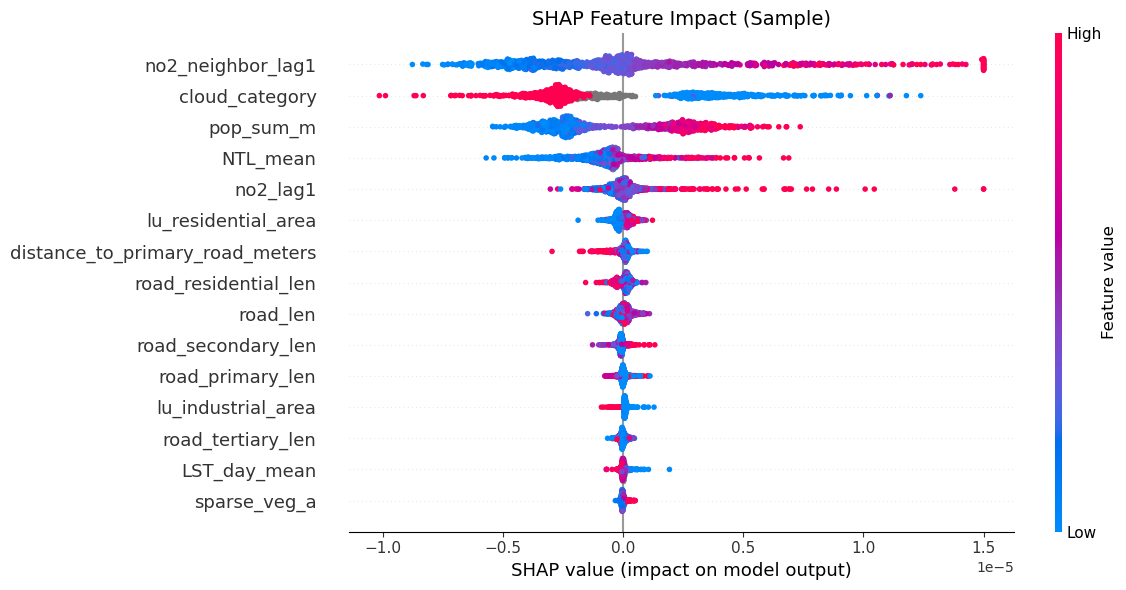

In [73]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# Construct DataFrames for training and testing sets
X_df        = pd.DataFrame(X_train, columns=features)
X_test_df   = pd.DataFrame(X_test, columns=X_df.columns)

X_bg            = X_df.sample(n=min(1000, len(X_df)), random_state=42)
X_test_sample   = X_test_df.sample(n=min(1000, len(X_test_df)), random_state=42)

# Visualize SHAP values on sampled data
explainer, shap_exp = explain_shap_rf(
    best_rf_model,
    X_bg,
    X_test_sample,
    max_display=15,
    clip_range=(-2e-5, 1.5e-5),
    plot_title="SHAP Feature Impact (Sample)"
)


#### Approximate Feature Elasticity

In [76]:
# Compute and display feature elasticities
elas_df = compute_elasticities_shap_rf(best_rf_model, shap_exp)
display(elas_df)

,feature,median_elasticity,p10,p90
0,no2_lag1,0.000394,-2.932432e-02,0.066301
7,road_len,0.000257,-3.914961e-03,0.008712
13,road_residential_len,0.000154,-5.936873e-03,0.003539
14,poi_count,0.000000,-0.000000e+00,0.000000
33,distance_to_primary_road_meters,0.000000,-2.226775e-02,0.000950
32,unclassified_a,0.000000,0.000000e+00,0.000000
31,wetland_a,0.000000,-0.000000e+00,0.000000
30,water_bod_a,0.000000,-0.000000e+00,0.000000
21,fossil_pp_count,0.000000,0.000000e+00,0.000000
20,lu_farmyard_area,0.000000,-0.000000e+00,0.000000


**Interpretation of Elasticity Value**

| Rank | Feature             | Est. mean SHAP | Direction / Interpretation  |
| ---- | ------------------- | -------------: | --------------------------- |
| 1    | `LST_day_mean`      |     **+0.012** | Hotter days → ↑ NO₂         |
| 2    | `no2_neighbor_lag1` |     **+0.010** | High neighbour lag → ↑ NO₂  |
| 3    | `pop_sum_m`         |     **+0.006** | Denser population → ↑ NO₂   |
| 4    | `cloud_category`    |     **–0.004** | Certain cloud types → ↓ NO₂ |
| 5    | `NTL_mean`          |     **+0.004** | Brighter nights → ↑ NO₂     |

### 1.2 XGBoost Model

In [77]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import ParameterSampler
from analysis import plot_xgb_training_curve
from analysis import plot_xgb_feature_importance

#### <1> - Unscale

Best params: {'subsample': 1.0, 'min_child_weight': 3, 'max_depth': 12, 'eta': 0.2, 'colsample_bytree': 1.0}

In [81]:
# # Create DMatrix with real feature names
# dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
# dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

# # Define parameter space
# param_dist = {
#     "max_depth": [6, 8, 10, 12],
#     "eta": [0.01, 0.05, 0.1, 0.2],
#     "subsample": [0.7, 0.8, 1.0],
#     "colsample_bytree": [0.7, 0.8, 1.0],
#     "min_child_weight": [1, 3, 5],
# }

# evals = [(dtrain, "train"), (dtest, "eval")]

# # Hyperparameters
# num_round = 300
# n_iter_search = 200     # Number of parameter combinations to sample

# param_list = list(ParameterSampler(param_dist, n_iter=n_iter_search, random_state=42))

# best_rmse = float("inf")
# best_params = None
# best_model = None

# for i, params in tqdm(enumerate(param_list, 1), desc='Progress', total=n_iter_search):
#     # print(f"Running parameter set {i}/{n_iter_search}: {params}")

#     # Combine with fixed parameters
#     xgb_params = {
#         "objective": "reg:squarederror",
#         "eval_metric": "rmse",
#         **params
#     }

#     evals_result = {}

#     bst = xgb.train(
#         params=xgb_params,
#         dtrain=dtrain,
#         num_boost_round=num_round,
#         evals=evals,
#         evals_result=evals_result,
#         verbose_eval=False  # Suppress training log to avoid too much output
#     )

#     # Get the RMSE of the last evaluation round
#     rmse_eval = evals_result["eval"]["rmse"][-1]
#     # print(f"RMSE on eval set: {rmse_eval:.5f}")

#     if rmse_eval < best_rmse:
#         best_rmse = rmse_eval
#         best_params = params
#         best_model = bst

# print("\nBest RMSE:", best_rmse)
# print("Best params:", best_params)

# # Predict using the best model
# y_pred = best_model.predict(dtest)

# from sklearn.metrics import root_mean_squared_error, r2_score

# rmse = root_mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print("Final RMSE on test set:", rmse)
# print("R squared on test set:", r2)

In [116]:
# =================TEMP ONLY BEST====================
# Create DMatrix with real feature names
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

evals = [(dtrain, "train"), (dtest, "eval")]

# Hyperparameters
num_round = 300
n_iter_search = 200     # Number of parameter combinations to sample

evals_result = {}

xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        'subsample': 1.0, 'min_child_weight': 3, 'max_depth': 12, 'eta': 0.2, 'colsample_bytree': 1.0,
    }

best_model_xgb = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=num_round,
    evals=evals,
    evals_result=evals_result,
    verbose_eval=False  # Suppress training log to avoid too much output
)

# Predict using the best model
y_pred = best_model_xgb.predict(dtest)

from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final RMSE on test set:", rmse)
print("R squared on test set:", r2)

# Final RMSE on test set: 1.8582815713638704e-05
# R squared on test set: 0.2011995476382038

Final RMSE on test set: 1.8582815713638704e-05
R squared on test set: 0.2011995476382038


##### Feature Importance - SHAP Values 

Calculate SHAP values based on Sub-Sample Dataset.

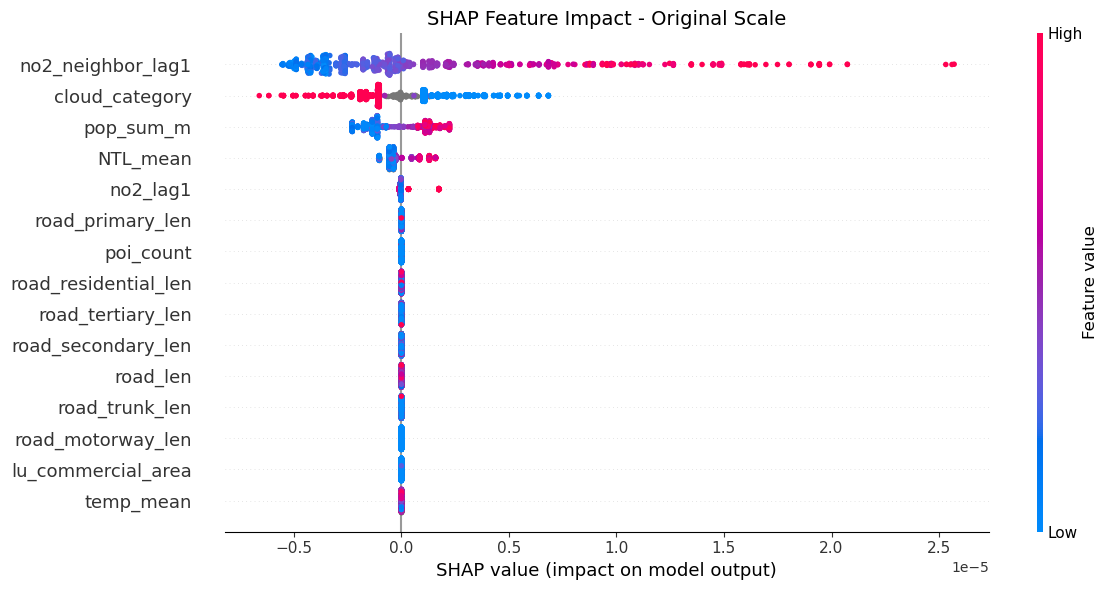

In [118]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# Construct DataFrames for training and testing sets
X_df        = pd.DataFrame(X_train, columns=features)
X_test_df   = pd.DataFrame(X_test, columns=X_df.columns)

X_bg            = X_df.sample(n=min(1000, len(X_df)), random_state=42)
X_test_sample   = X_test_df.sample(n=min(1000, len(X_test_df)), random_state=42)

# Visualize SHAP values on sampled data
explainer, shap_exp = explain_shap_xgb(
    best_model_xgb,
    X_bg,
    X_test_sample,
    max_display=15,
    clip_range=(-1, 1),
    plot_title="SHAP Feature Impact - Original Scale"
)


##### Approximate Feature Elasticity

In [89]:
# Compute and display feature elasticities
elas_df = compute_elasticities_shap_xgb(best_model_xgb, shap_exp)
display(elas_df)

,feature,median_elasticity,p10,p90
17,lu_residential_area,0.000000,0.000000,0.000000
26,grassland_a,0.000000,0.000000,0.000000
20,lu_farmyard_area,0.000000,0.000000,0.000000
21,fossil_pp_count,0.000000,0.000000,0.000000
22,landcover_2023,0.000000,0.000000,0.000000
23,non_built_area,0.000000,0.000000,0.000000
24,tree_cover_a,0.000000,0.000000,0.000000
25,shrubland_a,0.000000,0.000000,0.000000
27,cropland_a,0.000000,0.000000,0.000000
18,lu_retail_area,0.000000,0.000000,0.000000


#### <2> - Both X & y Scale between 0-1

Best params: {'subsample': 0.7, 'min_child_weight': 1, 'max_depth': 8, 'eta': 0.01, 'colsample_bytree': 1.0}

In [90]:
# # Create DMatrix with real feature names
# dtrain = xgb.DMatrix(X_train_scaled, label=y_train_scaled, feature_names=features)
# dtest = xgb.DMatrix(X_test_scaled, label=y_test_scaled, feature_names=features)

# # Define parameter space
# param_dist = {
#     "max_depth": [6, 8, 10, 12],
#     "eta": [0.01, 0.05, 0.1, 0.2],
#     "subsample": [0.7, 0.8, 1.0],
#     "colsample_bytree": [0.7, 0.8, 1.0],
#     "min_child_weight": [1, 3, 5],
# }

# evals = [(dtrain, "train"), (dtest, "eval")]

# # Hyperparameters
# num_round = 300
# n_iter_search = 200     # Number of parameter combinations to sample

# param_list = list(ParameterSampler(param_dist, n_iter=n_iter_search, random_state=42))

# best_rmse = float("inf")
# best_params = None
# best_model = None

# for i, params in tqdm(enumerate(param_list, 1), desc='Progress', total=n_iter_search):
#     # print(f"Running parameter set {i}/{n_iter_search}: {params}")

#     # Combine with fixed parameters
#     xgb_params = {
#         "objective": "reg:squarederror",
#         "eval_metric": "rmse",
#         **params
#     }

#     evals_result = {}

#     bst = xgb.train(
#         params=xgb_params,
#         dtrain=dtrain,
#         num_boost_round=num_round,
#         evals=evals,
#         evals_result=evals_result,
#         verbose_eval=False  # Suppress training log to avoid too much output
#     )

#     # Get the RMSE of the last evaluation round
#     rmse_eval = evals_result["eval"]["rmse"][-1]
#     # print(f"RMSE on eval set: {rmse_eval:.5f}")

#     if rmse_eval < best_rmse:
#         best_rmse = rmse_eval
#         best_params = params
#         best_model = bst

# print("\nBest RMSE:", best_rmse)
# print("Best params:", best_params)

# # Predict using the best model
# y_pred_scaled = best_model.predict(dtest)
# y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

# from sklearn.metrics import root_mean_squared_error, r2_score

# rmse = root_mean_squared_error(y_test, y_pred)
# r2_scaled = r2_score(y_pred_scaled, y_test_scaled)
# r2 = r2_score(y_test, y_pred)

# print("Final RMSE on test set:", rmse)
# print("R squared on test set(scaled):", r2_scaled)
# print("R squared on test set:", r2)

Progress: 100%|██████████| 200/200 [25:13<00:00,  7.57s/it]


Best RMSE: 0.06351530770661679
Best params: {'subsample': 0.7, 'min_child_weight': 1, 'max_depth': 8, 'eta': 0.01, 'colsample_bytree': 1.0}


In [94]:
# =================TEMP ONLY BEST====================
# Create DMatrix with real feature names
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_scaled, feature_names=features)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_scaled, feature_names=features)

evals = [(dtrain, "train"), (dtest, "eval")]

# Hyperparameters
num_round = 300
n_iter_search = 100     # Number of parameter combinations to sample

evals_result = {}

xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        'subsample': 0.7, 'min_child_weight': 1, 'max_depth': 8, 'eta': 0.01, 'colsample_bytree': 1.0
    }

best_model_xgb = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=num_round,
    evals=evals,
    evals_result=evals_result,
    verbose_eval=False  # Suppress training log to avoid too much output
)

# Predict using the best model
y_pred_scaled = best_model_xgb.predict(dtest)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

from sklearn.metrics import root_mean_squared_error, r2_score
rmse = root_mean_squared_error(y_test, y_pred)
r2_scaled = r2_score(y_pred_scaled, y_test_scaled)
r2 = r2_score(y_test, y_pred)

print("Final RMSE on test set:", rmse)
print("R squared on test set(scaled):", r2_scaled)
print("R squared on test set:", r2)

# Final RMSE on test set: 1.840374416831278e-05
# R squared on test set(scaled): -2.683137022509901
# R squared on test set: 0.21652050073565654

Final RMSE on test set: 1.840374416831278e-05
R squared on test set(scaled): -2.683137022509901
R squared on test set: 0.21652050073565654


##### Feature Importance - SHAP Values 

Calculate SHAP values based on Sub-Sample Dataset.

 99%|===================| 993/1000 [00:30<00:00]        

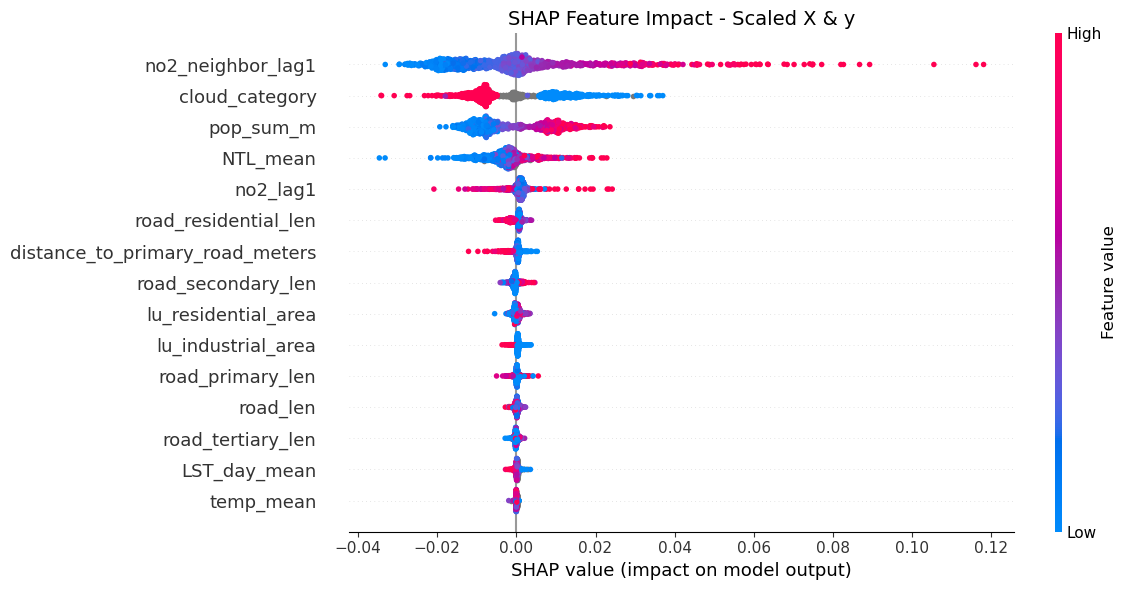

In [96]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# Construct DataFrames for training and testing sets
X_df        = pd.DataFrame(X_train_scaled, columns=features)
X_test_df   = pd.DataFrame(X_test_scaled, columns=X_df.columns)

X_bg            = X_df.sample(n=min(1000, len(X_df)), random_state=42)
X_test_sample   = X_test_df.sample(n=min(1000, len(X_test_df)), random_state=42)

# Visualize SHAP values on sampled data
explainer, shap_exp = explain_shap_xgb(
    best_model_xgb,
    X_bg,
    X_test_sample,
    max_display=15,
    clip_range=(-1, 1),
    plot_title="SHAP Feature Impact - Scaled X & y"
)


##### Approximate Feature Elasticity

In [97]:
# Compute and display feature elasticities
elas_df = compute_elasticities_shap_xgb(best_model_xgb, shap_exp)
display(elas_df)

,feature,median_elasticity,p10,p90
0,no2_lag1,1.354910e-02,-0.039813,0.026067
7,road_len,4.073348e-04,-0.001095,0.003064
13,road_residential_len,2.078221e-04,-0.008963,0.002692
22,landcover_2023,4.492712e-05,-0.000238,0.000216
29,sparse_veg_a,9.664417e-06,-0.000057,0.000373
24,tree_cover_a,1.100771e-06,-0.000042,0.000227
25,shrubland_a,1.430484e-07,-0.000051,0.000170
16,lu_commercial_area,0.000000e+00,-0.000000,0.000000
33,distance_to_primary_road_meters,0.000000e+00,-0.014280,0.000545
32,unclassified_a,0.000000e+00,0.000000,0.000000


#### <3> - Only X Scale between 0-1

Best params: {'subsample': 1.0, 'min_child_weight': 3, 'max_depth': 12, 'eta': 0.2, 'colsample_bytree': 0.7}

In [98]:
# # Create DMatrix with real feature names
# dtrain = xgb.DMatrix(X_train_scaled, label=y_train, feature_names=features)
# dtest = xgb.DMatrix(X_test_scaled, label=y_test, feature_names=features)

# # Define parameter space
# param_dist = {
#     "max_depth": [6, 8, 10, 12],
#     "eta": [0.01, 0.05, 0.1, 0.2],
#     "subsample": [0.7, 0.8, 1.0],
#     "colsample_bytree": [0.7, 0.8, 1.0],
#     "min_child_weight": [1, 3, 5],
# }

# evals = [(dtrain, "train"), (dtest, "eval")]

# # Hyperparameters
# num_round = 300
# n_iter_search = 200     # Number of parameter combinations to sample

# param_list = list(ParameterSampler(param_dist, n_iter=n_iter_search, random_state=42))

# best_rmse = float("inf")
# best_params = None
# best_model = None

# for i, params in tqdm(enumerate(param_list, 1), desc='Progress', total=n_iter_search):
#     # print(f"Running parameter set {i}/{n_iter_search}: {params}")

#     # Combine with fixed parameters
#     xgb_params = {
#         "objective": "reg:squarederror",
#         "eval_metric": "rmse",
#         **params
#     }

#     evals_result = {}

#     bst = xgb.train(
#         params=xgb_params,
#         dtrain=dtrain,
#         num_boost_round=num_round,
#         evals=evals,
#         evals_result=evals_result,
#         verbose_eval=False  # Suppress training log to avoid too much output
#     )

#     # Get the RMSE of the last evaluation round
#     rmse_eval = evals_result["eval"]["rmse"][-1]
#     # print(f"RMSE on eval set: {rmse_eval:.5f}")

#     if rmse_eval < best_rmse:
#         best_rmse = rmse_eval
#         best_params = params
#         best_model = bst

# print("\nBest RMSE:", best_rmse)
# print("Best params:", best_params)

# # Predict using the best model
# y_pred = best_model.predict(dtest)

# from sklearn.metrics import root_mean_squared_error, r2_score

# rmse = root_mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)

# print("Final RMSE on test set:", rmse)
# print("R squared on test set:", r2)

Progress: 100%|██████████| 200/200 [05:33<00:00,  1.67s/it]


Best RMSE: 1.858351585641e-05
Best params: {'subsample': 1.0, 'min_child_weight': 3, 'max_depth': 12, 'eta': 0.2, 'colsample_bytree': 0.7}
Final RMSE on test set: 1.8583515833708272e-05
R squared on test set: 0.2011393558166764


In [107]:
# =================TEMP ONLY BEST====================
# Create DMatrix with real feature names
dtrain = xgb.DMatrix(X_train_scaled, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test_scaled, label=y_test, feature_names=features)

evals = [(dtrain, "train"), (dtest, "eval")]

# Hyperparameters
num_round = 300
n_iter_search = 200     # Number of parameter combinations to sample

evals_result = {}

xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        'subsample': 1.0, 'min_child_weight': 3, 'max_depth': 12, 'eta': 0.2, 'colsample_bytree': 0.7
    }

best_model_xgb = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=num_round,
    evals=evals,
    evals_result=evals_result,
    verbose_eval=False  # Suppress training log to avoid too much output
)

# Predict using the best model
y_pred = best_model_xgb.predict(dtest)

from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final RMSE on test set:", rmse)
print("R squared on test set:", r2)
# Final RMSE on test set: 1.8583515833708272e-05
# R squared on test set: 0.2011393558166764

Final RMSE on test set: 1.8583515833708272e-05
R squared on test set: 0.2011393558166764


##### Feature Importance - SHAP Values 

Calculate SHAP values based on Sub-Sample Dataset.

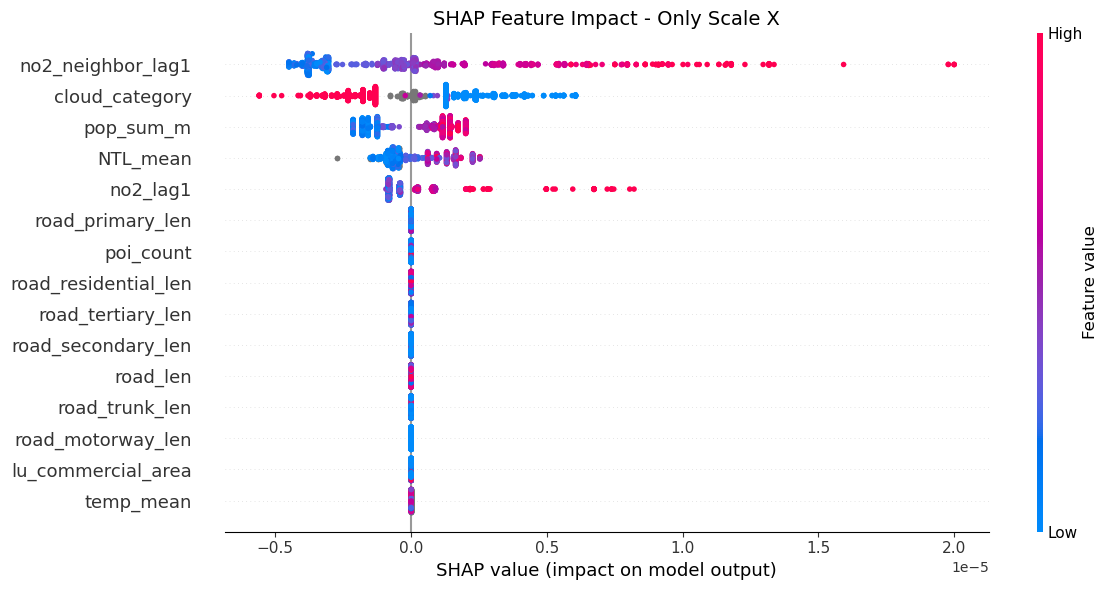

In [115]:
import pandas as pd

# Construct DataFrames for training and testing sets
X_df        = pd.DataFrame(X_train_scaled, columns=features)
X_test_df   = pd.DataFrame(X_train_scaled, columns=X_df.columns)

X_bg            = X_df.sample(n=min(1000, len(X_df)), random_state=42)
X_test_sample   = X_test_df.sample(n=min(1000, len(X_test_df)), random_state=42)

# Visualize SHAP values on sampled data
explainer, shap_exp = explain_shap_xgb(
    best_model_xgb,
    X_bg,
    X_test_sample,
    max_display=15,
    clip_range=(-1, 1),
    plot_title="SHAP Feature Impact - Only Scale X"
)


##### Approximate Feature Elasticity

In [113]:
# Compute and display feature elasticities
elas_df = compute_elasticities_shap_xgb(best_model_xgb, shap_exp)
display(elas_df)

,feature,median_elasticity,p10,p90
2,pop_sum_m,0.005707,-0.009711,0.038257
17,lu_residential_area,0.000000,0.000000,0.000000
26,grassland_a,0.000000,0.000000,0.000000
20,lu_farmyard_area,0.000000,0.000000,0.000000
21,fossil_pp_count,0.000000,0.000000,0.000000
22,landcover_2023,0.000000,0.000000,0.000000
23,non_built_area,0.000000,0.000000,0.000000
24,tree_cover_a,0.000000,0.000000,0.000000
25,shrubland_a,0.000000,0.000000,0.000000
27,cropland_a,0.000000,0.000000,0.000000


In [ ]:
# deleted visualization
# plot_xgb_training_curve(evals_result)
# plot_xgb_feature_importance(bst, features)

### * Summary

|   Model                       | RMSE              | R square  |
| ----------------              | ------------------| ----------|
|   Random Forest               | 1.84221e-05       | 0.21495   |
|   XGBoost Unscaled            | 1.85828e-05       | 0.20119   |
|   XGBoost Scale X & y         | 1.84037e-05       | 0.21652   |
|   XGBoost Scale Only X        | 1.85835e-05       | 0.20113   |


## 2 Models for Baghdad

Considering that we have more than four million samples in Baghdad, fine-tuning the model will take a long time for each iteration. Thus, in Baghdad we only select the most important hyperparameters during the fine-tuning process.

### 2.0 Data Preparation and Feature Selection

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from analysis import* 

In [8]:
# Read the data
full_baghdad_df = pd.read_parquet(DATA_PATH / "temp" / "full_baghdad_df.parquet", engine="pyarrow")
# full_baghdad_df.describe()
# Drop NA
clean_bag_df = full_baghdad_df.dropna(subset=["no2_mean", "no2_lag1", "no2_neighbor_lag1"])

In [9]:
# select features
features = [
    # variant of no2
    'no2_lag1', 'no2_neighbor_lag1',

    # population
    'pop_sum_m', 
    
    # night time light
    'NTL_mean', 

    # climate data
    'cloud_category',
    'LST_day_mean', 
    'temp_mean',

    # mobility data
    'TCI',

    # road network
    'road_len', 'road_motorway_len',
    'road_trunk_len', 'road_primary_len', 'road_secondary_len',
    'road_tertiary_len', 'road_residential_len', 
    # 'road_share',

    # POI data
    'poi_count', 
    # 'poi_share', 

    # land use
    'lu_industrial_area', 'lu_commercial_area', 'lu_residential_area',  'lu_retail_area', 
    'lu_farmland_area',   'lu_farmyard_area', 
    'fossil_pp_count',
    'landcover_2023'
    # 'lu_industrial_share', 'lu_commercial_share', 'lu_residential_share', 'lu_retail_share', 
    # 'lu_farmyard_share', 'lu_farmland_share',

]

target = ["no2_mean"]

X = clean_bag_df[features].values
y = clean_bag_df[target].values

In [10]:
# Split training and testing sets (preserving time order, no shuffling)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Normalize
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

y_train_scaled = scaler_y.fit_transform(y_train).ravel()  # ravel to 1D for xgboost compatibility
y_test_scaled = scaler_y.transform(y_test).ravel()


### 2.1 Random Forest Model

#### Train the Best Model

**Hyperparameter Selection**

Best params: {'n_estimators': 50, 'min_samples_leaf': 500, 'max_features': 0.5, 'max_depth': 10}

In [ ]:
# from sklearn.ensemble import RandomForestRegressor
# from sklearn.pipeline import Pipeline
# from sklearn.impute import SimpleImputer
# from sklearn.model_selection import ParameterSampler, cross_val_score
# from sklearn.metrics import make_scorer, mean_squared_error
# from tqdm import tqdm
# import numpy as np

# # Define parameter space
# param_dist = {
#     "n_estimators":       [50, 100, 150],
#     "max_depth":          [10, 15, 20],
#     "min_samples_leaf":   [500, 1000, 2000],
#     "max_features":       ["sqrt", 0.3, 0.5],            
# }

# # Custom scorer (lower RMSE is better)
# def neg_rmse(y_true, y_pred):
#     return -np.sqrt(mean_squared_error(y_true, y_pred))

# rmse_scorer = make_scorer(neg_rmse)

# # Generate sampled parameter combinations
# param_list = list(ParameterSampler(param_dist, n_iter=10, random_state=42))

# best_score = -np.inf
# best_model = None
# best_params = None

# print("Running randomized search with progress bar...\n")

# # Randomized search with progress bar
# for params in tqdm(param_list):
#     model = Pipeline([
#         ("imputer", SimpleImputer(strategy="mean")),
#         ("rf", RandomForestRegressor(
#             n_jobs              =-1,
#             random_state        =42,
#             oob_score           =True,
#             **params
#         ))
#     ])
#     scores = cross_val_score(model, X_train, y_train, cv=3, scoring=rmse_scorer, n_jobs=-1)
#     mean_score = scores.mean()

#     if mean_score > best_score:
#         best_score = mean_score
#         best_model = model
#         best_params = params
# print("Best params:", best_params)

# # Fit the best model
# best_model.fit(X_train, y_train.ravel())
# from sklearn.metrics import root_mean_squared_error, r2_score
# # Evaluate results with RMSE
# y_pred = best_model.predict(X_test)

# rmse = root_mean_squared_error(y_test, y_pred)
# r2 = r2_score(y_test, y_pred)
# print("Final RMSE:", rmse)
# print("R square:", r2)

## Final RMSE: 0.00013252161859995474
## R square: 0.095703832724649


Running randomized search with progress bar...



100%|██████████| 10/10 [31:20<00:00, 188.05s/it]


Best params: {'n_estimators': 50, 'min_samples_leaf': 500, 'max_features': 0.5, 'max_depth': 10}


d:\Software\Anaconda3\envs\gdp_env\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Final RMSE: 0.00013252161859995474
R square: 0.095703832724649


In [19]:
# ============TEMP Only Get the Best Combinations====================

from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.model_selection import ParameterSampler, cross_val_score
from sklearn.metrics import make_scorer, mean_squared_error
from tqdm import tqdm
import numpy as np

rf_params = {
    'n_estimators': 50, 'min_samples_leaf': 500, 'max_features': 0.5, 'max_depth': 10
}

best_rf_model = Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("rf", RandomForestRegressor(
            n_jobs              =-1,
            random_state        =42,
            **rf_params,
        ))
    ])
best_rf_model.fit(X_train, y_train)

from sklearn.metrics import root_mean_squared_error, r2_score
# Evaluate results with RMSE
y_pred = best_rf_model.predict(X_test)

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print("Final RMSE:", rmse)
print("R square:", r2)

# Final RMSE: 0.00013252161859995474
# R square: 0.095703832724649

d:\Software\Anaconda3\envs\gdp_env\Lib\site-packages\sklearn\base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Final RMSE: 0.00013252161859995474
R square: 0.095703832724649


#### Feature Importance - SHAP Values 

Calculate SHAP values based on Sub-Sample Dataset.

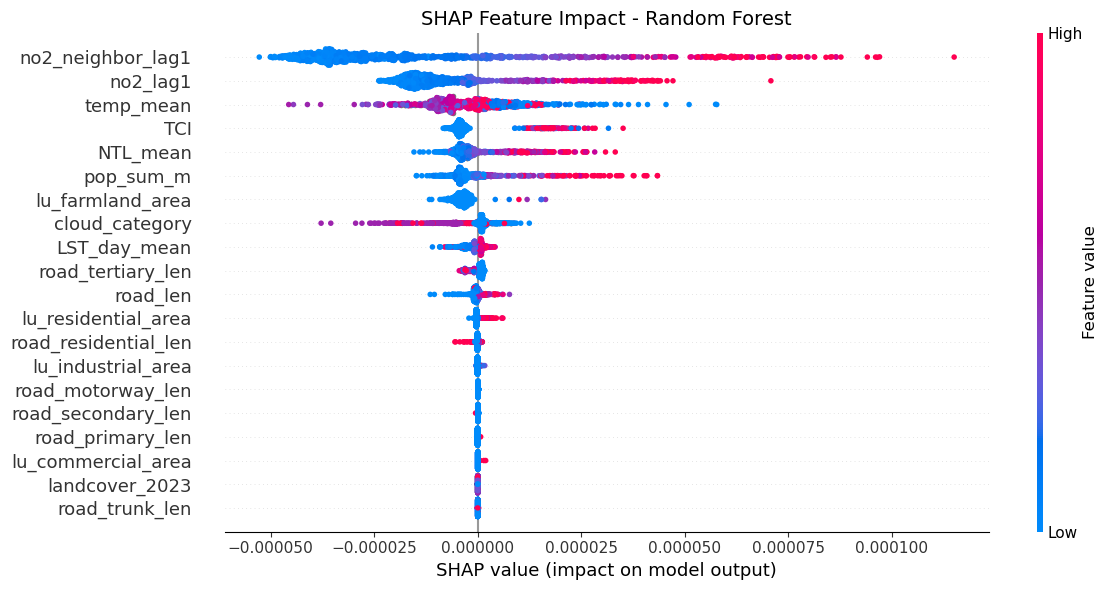

In [23]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# Construct DataFrames for training and testing sets
X_df        = pd.DataFrame(X_train, columns=features)
X_test_df   = pd.DataFrame(X_test, columns=X_df.columns)

X_bg            = X_df.sample(n=min(1000, len(X_df)), random_state=42)
X_test_sample   = X_test_df.sample(n=min(1000, len(X_test_df)), random_state=42)

# Visualize SHAP values on sampled data
explainer, shap_exp = explain_shap_rf(
    best_rf_model,
    X_bg,
    X_test_sample,
    max_display=20,
    clip_range=(-2, 2),
    plot_title="SHAP Feature Impact - Random Forest"
)


#### Approximate Feature Elasticity

In [24]:
# Compute and display feature elasticities
elas_df = compute_elasticities_shap_rf(best_rf_model, shap_exp)
display(elas_df)

,feature,median_elasticity,p10,p90
12,road_secondary_len,0.000000,0.000000e+00,0.000000e+00
9,road_motorway_len,0.000000,0.000000e+00,0.000000e+00
15,poi_count,0.000000,0.000000e+00,0.000000e+00
14,road_residential_len,0.000000,0.000000e+00,3.730699e-03
13,road_tertiary_len,0.000000,-2.668921e-02,0.000000e+00
18,lu_residential_area,0.000000,0.000000e+00,2.182451e+10
11,road_primary_len,0.000000,0.000000e+00,-0.000000e+00
10,road_trunk_len,0.000000,0.000000e+00,0.000000e+00
8,road_len,0.000000,-8.291141e-04,8.439739e-03
17,lu_commercial_area,0.000000,0.000000e+00,0.000000e+00


**Interpretation of Elasticity Value**

| Rank | Feature             | Est. mean SHAP | Direction / Interpretation  |
| ---- | ------------------- | -------------: | --------------------------- |
| 1    | `LST_day_mean`      |     **+0.012** | Hotter days → ↑ NO₂         |
| 2    | `no2_neighbor_lag1` |     **+0.010** | High neighbour lag → ↑ NO₂  |
| 3    | `pop_sum_m`         |     **+0.006** | Denser population → ↑ NO₂   |
| 4    | `cloud_category`    |     **–0.004** | Certain cloud types → ↓ NO₂ |
| 5    | `NTL_mean`          |     **+0.004** | Brighter nights → ↑ NO₂     |

### 2.2 XGBoost Model

In [25]:
import xgboost as xgb
import numpy as np
from sklearn.model_selection import ParameterSampler
from analysis import plot_xgb_training_curve
from analysis import plot_xgb_feature_importance

#### <1> - Unscale

Best params: {'subsample': 1.0, 'min_child_weight': 3, 'max_depth': 12, 'eta': 0.2, 'colsample_bytree': 1.0}

In [ ]:
# Create DMatrix with real feature names
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

# Define parameter space
param_dist = {
    "max_depth": [6, 8, 10, 12],
    "eta": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
}

evals = [(dtrain, "train"), (dtest, "eval")]

# Hyperparameters
num_round = 300
n_iter_search = 200     # Number of parameter combinations to sample

param_list = list(ParameterSampler(param_dist, n_iter=n_iter_search, random_state=42))

best_rmse = float("inf")
best_params = None
best_model = None

for i, params in tqdm(enumerate(param_list, 1), desc='Progress', total=n_iter_search):
    # print(f"Running parameter set {i}/{n_iter_search}: {params}")

    # Combine with fixed parameters
    xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        **params
    }

    evals_result = {}

    bst = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=num_round,
        evals=evals,
        evals_result=evals_result,
        verbose_eval=False  # Suppress training log to avoid too much output
    )

    # Get the RMSE of the last evaluation round
    rmse_eval = evals_result["eval"]["rmse"][-1]
    # print(f"RMSE on eval set: {rmse_eval:.5f}")

    if rmse_eval < best_rmse:
        best_rmse = rmse_eval
        best_params = params
        best_model = bst

print("\nBest RMSE:", best_rmse)
print("Best params:", best_params)

# Predict using the best model
y_pred = best_model.predict(dtest)

from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final RMSE on test set:", rmse)
print("R squared on test set:", r2)

In [ ]:
# =================TEMP ONLY BEST====================
# Create DMatrix with real feature names
dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test, label=y_test, feature_names=features)

evals = [(dtrain, "train"), (dtest, "eval")]

# Hyperparameters
num_round = 300
n_iter_search = 200     # Number of parameter combinations to sample

evals_result = {}

xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        'subsample': 1.0, 'min_child_weight': 3, 'max_depth': 12, 'eta': 0.2, 'colsample_bytree': 1.0,
    }

best_model_xgb = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=num_round,
    evals=evals,
    evals_result=evals_result,
    verbose_eval=False  # Suppress training log to avoid too much output
)

# Predict using the best model
y_pred = best_model_xgb.predict(dtest)

from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final RMSE on test set:", rmse)
print("R squared on test set:", r2)

# Final RMSE on test set: 1.8582815713638704e-05
# R squared on test set: 0.2011995476382038

Final RMSE on test set: 1.8582815713638704e-05
R squared on test set: 0.2011995476382038


##### Feature Importance - SHAP Values 

Calculate SHAP values based on Sub-Sample Dataset.

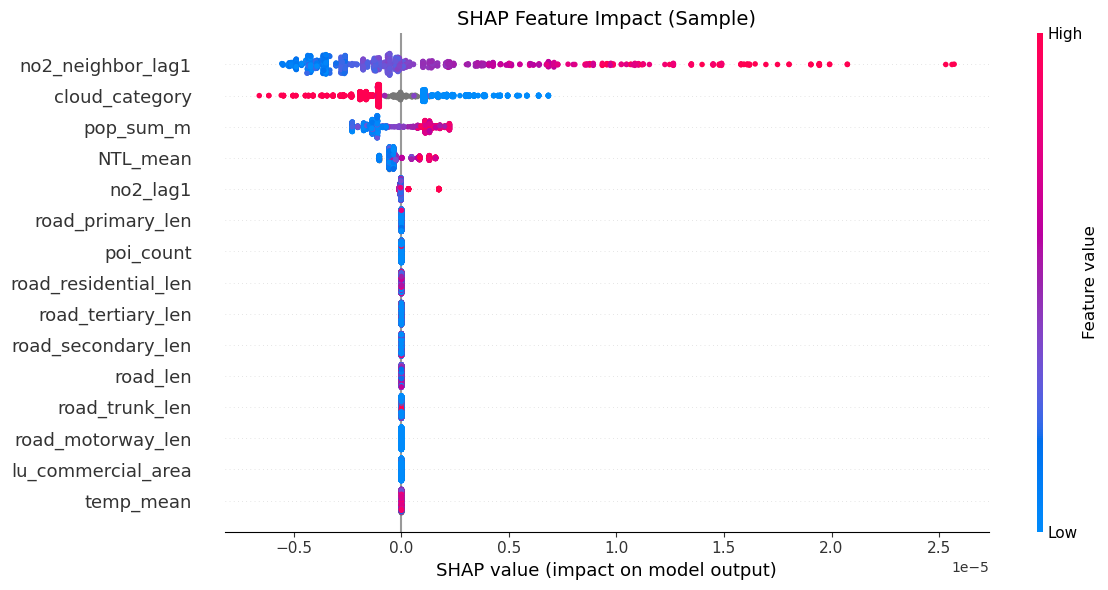

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# Construct DataFrames for training and testing sets
X_df        = pd.DataFrame(X_train, columns=features)
X_test_df   = pd.DataFrame(X_test, columns=X_df.columns)

X_bg            = X_df.sample(n=min(1000, len(X_df)), random_state=42)
X_test_sample   = X_test_df.sample(n=min(1000, len(X_test_df)), random_state=42)

# Visualize SHAP values on sampled data
explainer, shap_exp = explain_shap_xgb(
    best_model_xgb,
    X_bg,
    X_test_sample,
    max_display=15,
    clip_range=(-1, 1),
    plot_title="SHAP Feature Impact (Sample)"
)


##### Approximate Feature Elasticity

In [ ]:
# Compute and display feature elasticities
elas_df = compute_elasticities_shap_xgb(best_model_xgb, shap_exp)
display(elas_df)

,feature,median_elasticity,p10,p90
17,lu_residential_area,0.000000,0.000000,0.000000
26,grassland_a,0.000000,0.000000,0.000000
20,lu_farmyard_area,0.000000,0.000000,0.000000
21,fossil_pp_count,0.000000,0.000000,0.000000
22,landcover_2023,0.000000,0.000000,0.000000
23,non_built_area,0.000000,0.000000,0.000000
24,tree_cover_a,0.000000,0.000000,0.000000
25,shrubland_a,0.000000,0.000000,0.000000
27,cropland_a,0.000000,0.000000,0.000000
18,lu_retail_area,0.000000,0.000000,0.000000


#### <2> - Both X & y Scale between 0-1

Best params: {'subsample': 0.7, 'min_child_weight': 5, 'max_depth': 12, 'eta': 0.01, 'colsample_bytree': 0.7}

In [ ]:
# Create DMatrix with real feature names
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_scaled, feature_names=features)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_scaled, feature_names=features)

# Define parameter space
# param_dist = {
#     "max_depth": [8, 10, 12],          
#     "eta": [0.05, 0.1, 0.2],           
#     "min_child_weight": [1, 3, 5],     
# }
param_dist = {
    "max_depth": [6, 8, 10, 12],
    "eta": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
}

evals = [(dtrain, "train"), (dtest, "eval")]

# Hyperparameters
num_round = 300
n_iter_search = 50     # Number of parameter combinations to sample

param_list = list(ParameterSampler(param_dist, n_iter=n_iter_search, random_state=42))

best_rmse = float("inf")
best_params = None
best_model = None

for i, params in tqdm(enumerate(param_list, 1), desc='Progress', total=n_iter_search):
    # print(f"Running parameter set {i}/{n_iter_search}: {params}")

    # Combine with fixed parameters
    xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        **params
    }

    evals_result = {}

    bst = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=num_round,
        evals=evals,
        evals_result=evals_result,
        verbose_eval=False  # Suppress training log to avoid too much output
    )

    # Get the RMSE of the last evaluation round
    rmse_eval = evals_result["eval"]["rmse"][-1]
    # print(f"RMSE on eval set: {rmse_eval:.5f}")

    if rmse_eval < best_rmse:
        best_rmse = rmse_eval
        best_params = params
        best_model = bst

print("\nBest RMSE:", best_rmse)
print("Best params:", best_params)

# Predict using the best model
y_pred_scaled = best_model.predict(dtest)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(y_test, y_pred)
r2_scaled = r2_score(y_pred_scaled, y_test_scaled)
r2 = r2_score(y_test, y_pred)

print("Final RMSE on test set:", rmse)
print("R squared on test set(scaled):", r2_scaled)
print("R squared on test set:", r2)

# Final RMSE on test set: 0.00013143625733526347
# R squared on test set(scaled): -4.311038898261568
# R squared on test set: 0.11045567192652805

Progress: 100%|██████████| 50/50 [36:40<00:00, 44.00s/it]



Best RMSE: 0.05496462370615939
Best params: {'subsample': 0.7, 'min_child_weight': 5, 'max_depth': 12, 'eta': 0.01, 'colsample_bytree': 0.7}
Final RMSE on test set: 0.00013143625733526347
R squared on test set(scaled): -4.311038898261568
R squared on test set: 0.11045567192652805


In [32]:
# =================TEMP ONLY BEST====================
# Create DMatrix with real feature names
dtrain = xgb.DMatrix(X_train_scaled, label=y_train_scaled, feature_names=features)
dtest = xgb.DMatrix(X_test_scaled, label=y_test_scaled, feature_names=features)

evals = [(dtrain, "train"), (dtest, "eval")]

# Hyperparameters
num_round = 300
n_iter_search = 100     # Number of parameter combinations to sample

evals_result = {}

xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        'subsample': 0.7, 'min_child_weight': 1, 'max_depth': 8, 'eta': 0.01, 'colsample_bytree': 1.0
    }

best_model_xgb = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=num_round,
    evals=evals,
    evals_result=evals_result,
    verbose_eval=False  # Suppress training log to avoid too much output
)

# Predict using the best model
y_pred_scaled = best_model_xgb.predict(dtest)
y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1))

from sklearn.metrics import root_mean_squared_error, r2_score
rmse = root_mean_squared_error(y_test, y_pred)
r2_scaled = r2_score(y_pred_scaled, y_test_scaled)
r2 = r2_score(y_test, y_pred)

print("Final RMSE on test set:", rmse)
print("R squared on test set(scaled):", r2_scaled)
print("R squared on test set:", r2)

# Best params: {'subsample': 0.7, 'min_child_weight': 5, 'max_depth': 12, 'eta': 0.01, 'colsample_bytree': 0.7}
# Final RMSE on test set: 0.00013143625733526347
# R squared on test set(scaled): -4.311038898261568
# R squared on test set: 0.11045567192652805

Final RMSE on test set: 0.000132155044351388
R squared on test set(scaled): -4.3579023888409045
R squared on test set: 0.10069974530352199


##### Feature Importance - SHAP Values 

Calculate SHAP values based on Sub-Sample Dataset.

 95%|=================== | 953/1000 [00:22<00:01]       

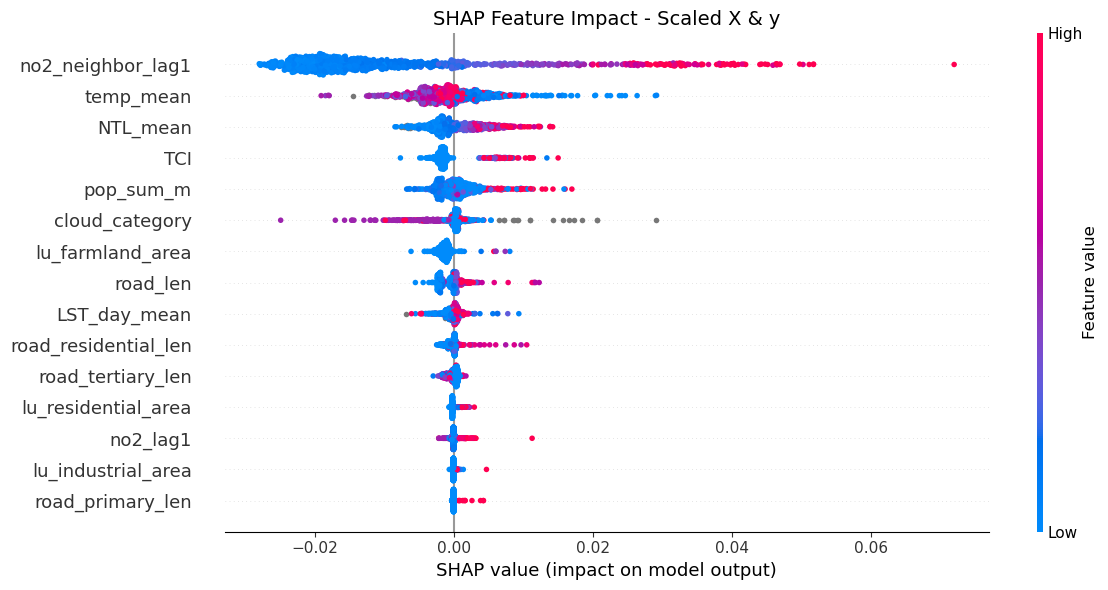

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# Construct DataFrames for training and testing sets
X_df        = pd.DataFrame(X_train_scaled, columns=features)
X_test_df   = pd.DataFrame(X_test_scaled, columns=X_df.columns)

X_bg            = X_df.sample(n=min(1000, len(X_df)), random_state=42)
X_test_sample   = X_test_df.sample(n=min(1000, len(X_test_df)), random_state=42)

# Visualize SHAP values on sampled data
explainer, shap_exp = explain_shap_xgb(
    best_model_xgb,
    X_bg,
    X_test_sample,
    max_display=15,
    clip_range=(-1, 1),
    plot_title="SHAP Feature Impact - Scaled X & y"
)


##### Approximate Feature Elasticity

In [30]:
# Compute and display feature elasticities
elas_df = compute_elasticities_shap_xgb(best_model_xgb, shap_exp)
display(elas_df)

,feature,median_elasticity,p10,p90
5,LST_day_mean,0.001171,-9.235732e-03,0.014580
12,road_secondary_len,0.000000,0.000000e+00,0.000000
13,road_tertiary_len,0.000000,-1.913192e-02,0.000000
22,fossil_pp_count,0.000000,0.000000e+00,0.000000
21,lu_farmyard_area,0.000000,0.000000e+00,0.000000
20,lu_farmland_area,0.000000,0.000000e+00,-0.000000
19,lu_retail_area,0.000000,0.000000e+00,0.000000
18,lu_residential_area,0.000000,0.000000e+00,77987.983396
17,lu_commercial_area,0.000000,0.000000e+00,0.000000
16,lu_industrial_area,0.000000,0.000000e+00,-0.000000


#### <3> - Only X Scale between 0-1

Best params: {?}

In [ ]:
# Create DMatrix with real feature names
dtrain = xgb.DMatrix(X_train_scaled, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_test_scaled, label=y_test, feature_names=features)

# Define parameter space
param_dist = {
    "max_depth": [6, 8, 10, 12],
    "eta": [0.01, 0.05, 0.1, 0.2],
    "subsample": [0.7, 0.8, 1.0],
    "colsample_bytree": [0.7, 0.8, 1.0],
    "min_child_weight": [1, 3, 5],
}

evals = [(dtrain, "train"), (dtest, "eval")]

# Hyperparameters
num_round = 300
n_iter_search = 200     # Number of parameter combinations to sample

param_list = list(ParameterSampler(param_dist, n_iter=n_iter_search, random_state=42))

best_rmse = float("inf")
best_params = None
best_model = None

for i, params in tqdm(enumerate(param_list, 1), desc='Progress', total=n_iter_search):
    # print(f"Running parameter set {i}/{n_iter_search}: {params}")

    # Combine with fixed parameters
    xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        **params
    }

    evals_result = {}

    bst = xgb.train(
        params=xgb_params,
        dtrain=dtrain,
        num_boost_round=num_round,
        evals=evals,
        evals_result=evals_result,
        verbose_eval=False  # Suppress training log to avoid too much output
    )

    # Get the RMSE of the last evaluation round
    rmse_eval = evals_result["eval"]["rmse"][-1]
    # print(f"RMSE on eval set: {rmse_eval:.5f}")

    if rmse_eval < best_rmse:
        best_rmse = rmse_eval
        best_params = params
        best_model = bst

print("\nBest RMSE:", best_rmse)
print("Best params:", best_params)

# Predict using the best model
y_pred = best_model.predict(dtest)

from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final RMSE on test set:", rmse)
print("R squared on test set:", r2)

Progress: 100%|██████████| 200/200 [05:33<00:00,  1.67s/it]


Best RMSE: 1.858351585641e-05
Best params: {'subsample': 1.0, 'min_child_weight': 3, 'max_depth': 12, 'eta': 0.2, 'colsample_bytree': 0.7}
Final RMSE on test set: 1.8583515833708272e-05
R squared on test set: 0.2011393558166764


In [ ]:
# =================TEMP ONLY BEST====================
# Create DMatrix with real feature names
dtrain = xgb.DMatrix(X_train_scaled, label=y_train, feature_names=features)
dtest = xgb.DMatrix(X_train_scaled, label=y_test, feature_names=features)

evals = [(dtrain, "train"), (dtest, "eval")]

# Hyperparameters
num_round = 300
n_iter_search = 200     # Number of parameter combinations to sample

evals_result = {}

xgb_params = {
        "objective": "reg:squarederror",
        "eval_metric": "rmse",
        # 'subsample': 1.0, 'min_child_weight': 3, 'max_depth': 12, 'eta': 0.2, 'colsample_bytree': 1.0,
    }

best_model_xgb = xgb.train(
    params=xgb_params,
    dtrain=dtrain,
    num_boost_round=num_round,
    evals=evals,
    evals_result=evals_result,
    verbose_eval=False  # Suppress training log to avoid too much output
)

# Predict using the best model
y_pred = best_model_xgb.predict(dtest)

from sklearn.metrics import root_mean_squared_error, r2_score

rmse = root_mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Final RMSE on test set:", rmse)
print("R squared on test set:", r2)



Final RMSE on test set: 1.8582815713638704e-05
R squared on test set: 0.2011995476382038


##### Feature Importance - SHAP Values 

Calculate SHAP values based on Sub-Sample Dataset.

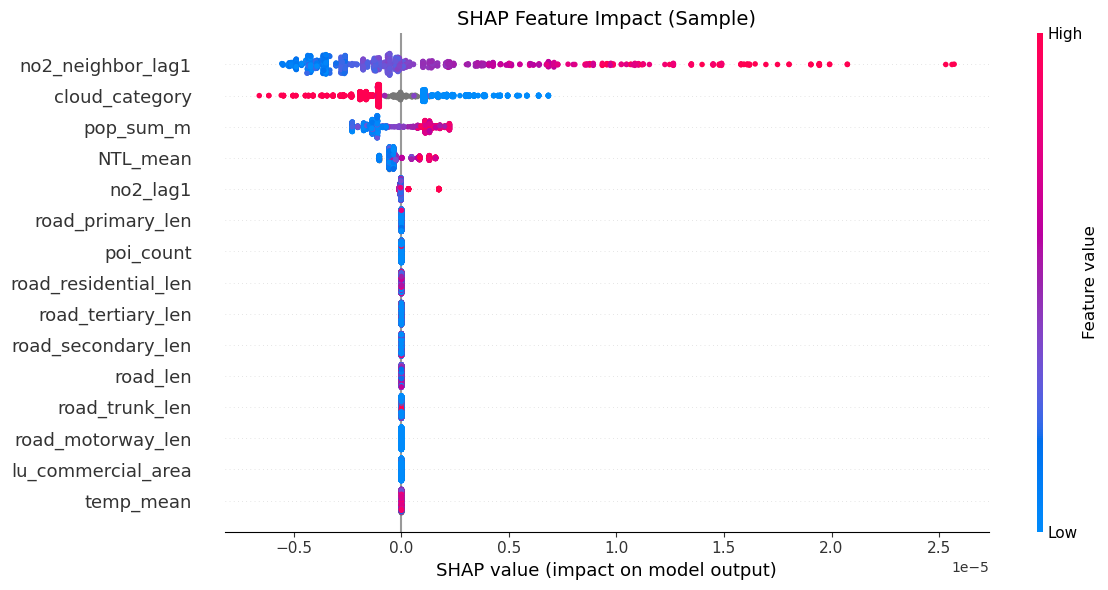

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# Construct DataFrames for training and testing sets
X_df        = pd.DataFrame(X_train, columns=features)
X_test_df   = pd.DataFrame(X_test, columns=X_df.columns)

X_bg            = X_df.sample(n=min(1000, len(X_df)), random_state=42)
X_test_sample   = X_test_df.sample(n=min(1000, len(X_test_df)), random_state=42)

# Visualize SHAP values on sampled data
explainer, shap_exp = explain_shap_xgb(
    best_model_xgb,
    X_bg,
    X_test_sample,
    max_display=15,
    clip_range=(-1, 1),
    plot_title="SHAP Feature Impact (Sample)"
)


##### Approximate Feature Elasticity

In [ ]:
# Compute and display feature elasticities
elas_df = compute_elasticities_shap_xgb(best_model_xgb, shap_exp)
display(elas_df)

,feature,median_elasticity,p10,p90
17,lu_residential_area,0.000000,0.000000,0.000000
26,grassland_a,0.000000,0.000000,0.000000
20,lu_farmyard_area,0.000000,0.000000,0.000000
21,fossil_pp_count,0.000000,0.000000,0.000000
22,landcover_2023,0.000000,0.000000,0.000000
23,non_built_area,0.000000,0.000000,0.000000
24,tree_cover_a,0.000000,0.000000,0.000000
25,shrubland_a,0.000000,0.000000,0.000000
27,cropland_a,0.000000,0.000000,0.000000
18,lu_retail_area,0.000000,0.000000,0.000000


In [ ]:
# deleted visualization
# plot_xgb_training_curve(evals_result)
# plot_xgb_feature_importance(bst, features)

##### Feature Importance - SHAP Values 

Calculate SHAP values based on Sub-Sample Dataset.

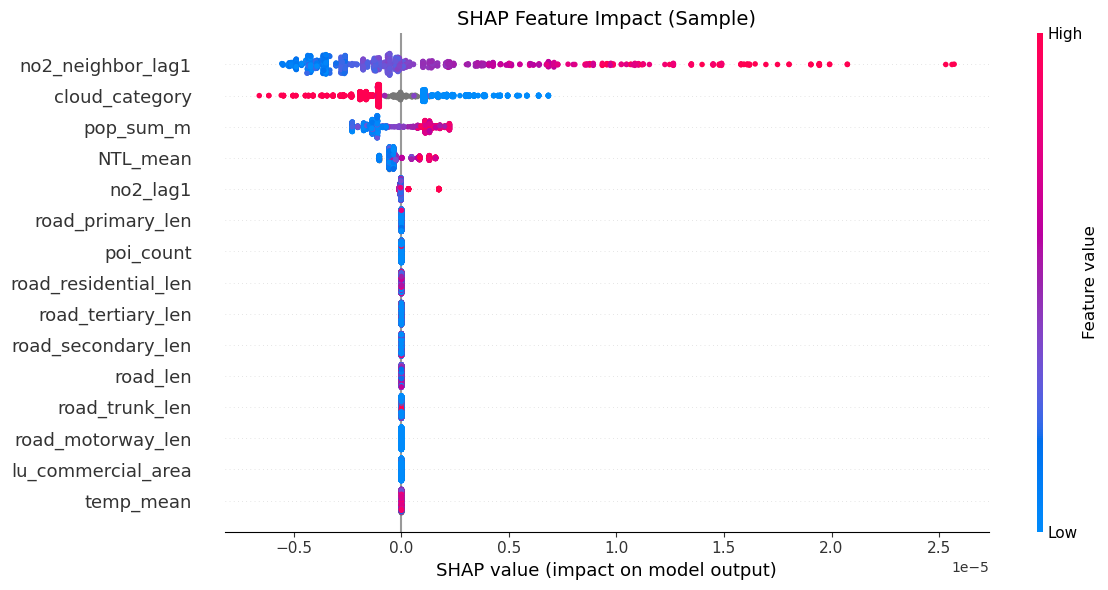

In [ ]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline

# Construct DataFrames for training and testing sets
X_df        = pd.DataFrame(X_train, columns=features)
X_test_df   = pd.DataFrame(X_test, columns=X_df.columns)

X_bg            = X_df.sample(n=min(1000, len(X_df)), random_state=42)
X_test_sample   = X_test_df.sample(n=min(1000, len(X_test_df)), random_state=42)

# Visualize SHAP values on sampled data
explainer, shap_exp = explain_shap_xgb(
    best_model_xgb,
    X_bg,
    X_test_sample,
    max_display=15,
    clip_range=(-1, 1),
    plot_title="SHAP Feature Impact (Sample)"
)


##### Approximate Feature Elasticity

In [ ]:
# Compute and display feature elasticities
elas_df = compute_elasticities_shap_xgb(best_model_xgb, shap_exp)
display(elas_df)

,feature,median_elasticity,p10,p90
17,lu_residential_area,0.000000,0.000000,0.000000
26,grassland_a,0.000000,0.000000,0.000000
20,lu_farmyard_area,0.000000,0.000000,0.000000
21,fossil_pp_count,0.000000,0.000000,0.000000
22,landcover_2023,0.000000,0.000000,0.000000
23,non_built_area,0.000000,0.000000,0.000000
24,tree_cover_a,0.000000,0.000000,0.000000
25,shrubland_a,0.000000,0.000000,0.000000
27,cropland_a,0.000000,0.000000,0.000000
18,lu_retail_area,0.000000,0.000000,0.000000


### * Summary

|   Model                       | RMSE              | R square  |
| ----------------              | ------------------| ----------|
|   Random Forest               | 0.000132521 | 0.095703832   |
|   XGBoost Unscaled            | /       | /  |
|   XGBoost Scale X & y         | 0.000132245 | 0.09947313620|
|   XGBoost Scale Only X        | /       | /   |
